In [1]:
from pathlib import Path
import numpy as np
import torch
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

from IPython.display import display
from PIL import Image
import decord
from einops import rearrange

np.set_printoptions(suppress=True)

In [2]:
p_hist_dir = Path('/data/gunsbrother/prjs/ltvu/ours/data/Ego4D-processed/hists/bins-16')

In [3]:
np.random.seed(0)
p_nlq_val_json = Path('/data/gunsbrother/prjs/ltvu/llms/GroundVQA/data/unified/annotations.NLQ_val.json')
nlq_val_data = json.load(p_nlq_val_json.open())
clip_uids = sorted(set(entry['video_id'] for entry in nlq_val_data))
clip_uids = np.random.permutation(clip_uids)

In [6]:
clip_uid = clip_uids[331]  # ref: 331
questions, gts = [], []
for entry in nlq_val_data:
	if entry['video_id'] == clip_uid:
		questions.append(entry['question'])
		gts.append((entry['clip_start_sec'], entry['clip_end_sec']))
gts = np.array(gts)

print(f'Clip UID: {clip_uid}')

Clip UID: 5e59031d-0deb-4557-a3e1-ba0ba2bb5465


5e59031d-0deb-4557-a3e1-ba0ba2bb5465


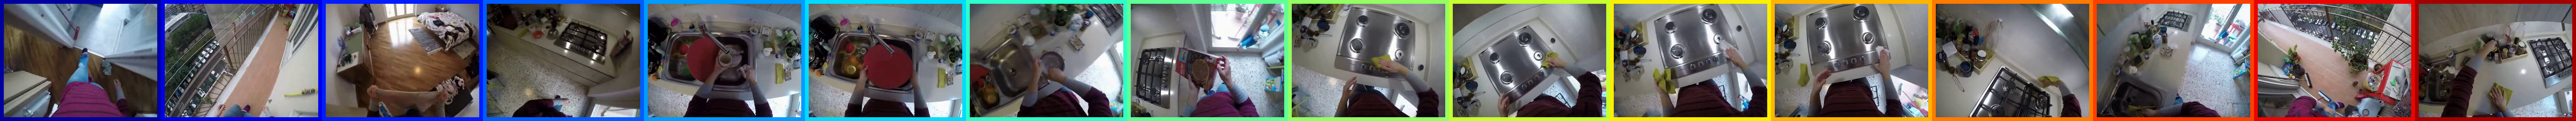

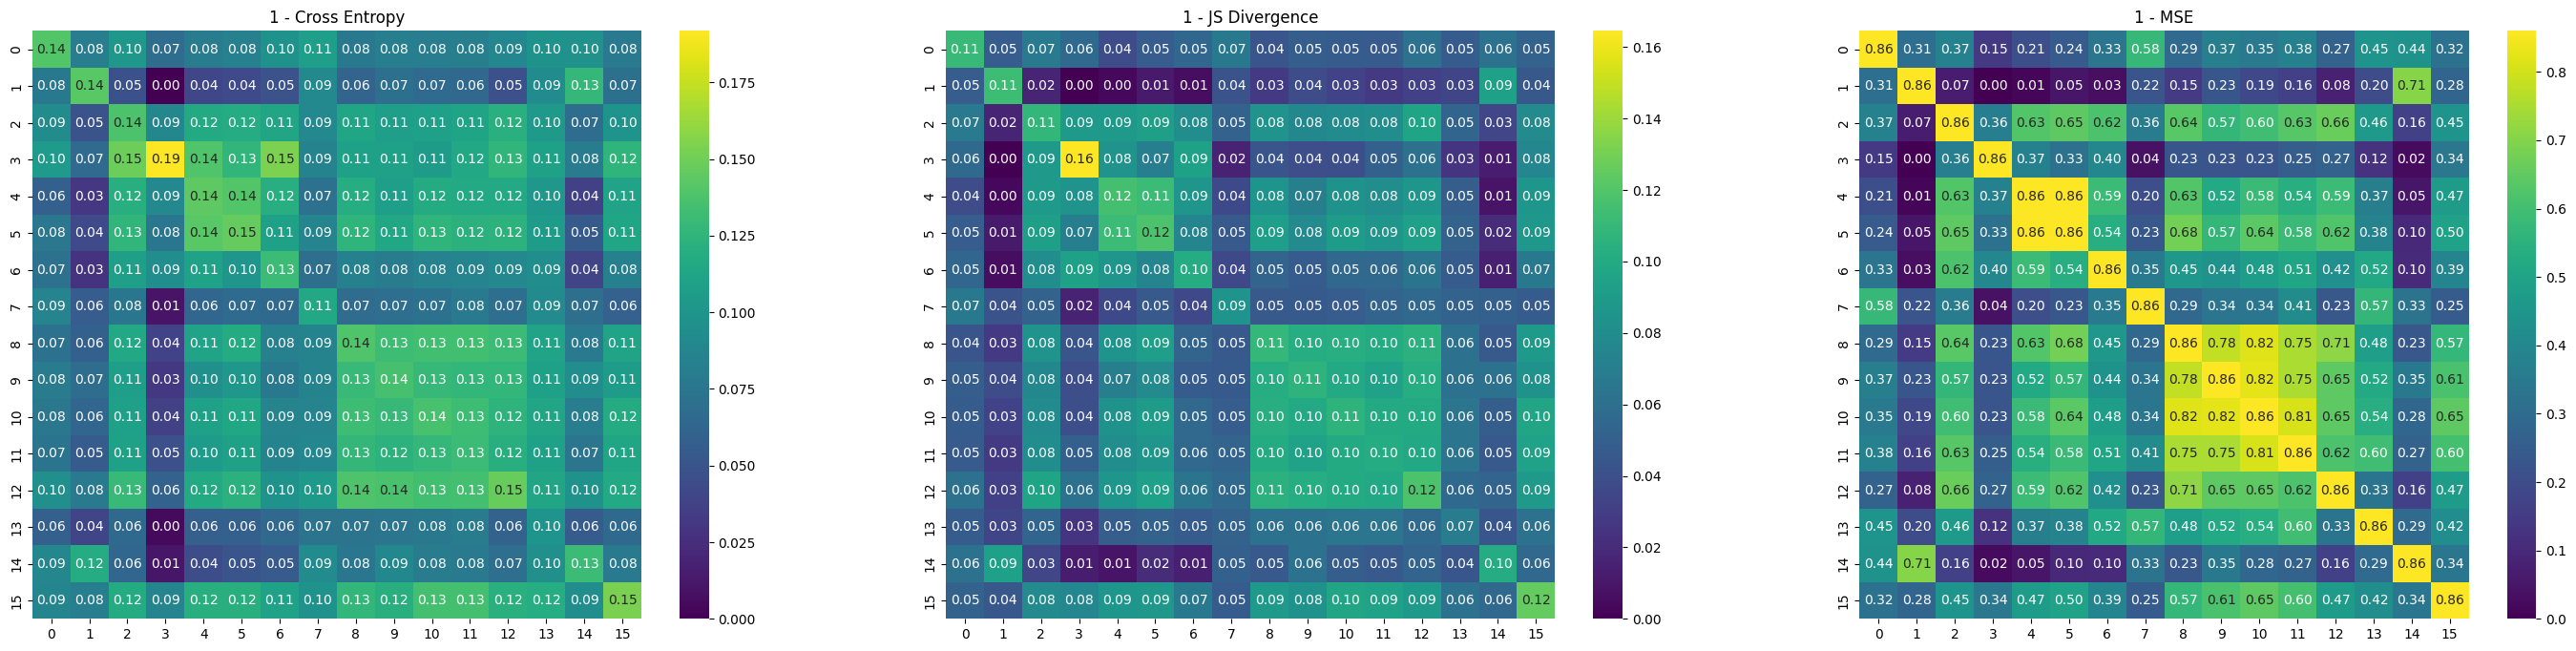

In [7]:
def show_frames(clip_uid):
	p_clip = Path('/data/datasets/ego4d_data/v2/clips_320p-non_official/') / f'{clip_uid}.mp4'
	vr = decord.VideoReader(str(p_clip))
	num_frames = 16
	border = 10
	frame_idxs = np.arange(len(vr)//num_frames//2, len(vr), len(vr)//num_frames)
	border_colors = plt.get_cmap('jet')(frame_idxs/len(vr))
	midframes = vr.get_batch(frame_idxs.tolist()).asnumpy()
	out_frames = midframes.copy()
	for i, frame in enumerate(midframes):
		frame[:border] = border_colors[i][:3] * 255
		frame[-border:] = border_colors[i][:3] * 255
		frame[:, :border] = border_colors[i][:3] * 255
		frame[:, -border:] = border_colors[i][:3] * 255
	midframes = rearrange(midframes, '(th tw) h w c -> (th h) (tw w) c', tw=num_frames)
	display(Image.fromarray(midframes))
	return frame_idxs, out_frames

def compute_color_hist(frames, bins=16):
    # frames: (T, H, W, 3)
    T, H, W, C = frames.shape
    frames = rearrange(frames, 't h w c -> t c h w')
    hists = []
    for frame in frames:
        hist_frame = []
        for channel in range(C):
            hist, _ = np.histogram(frame[channel].ravel(), bins=bins, range=(0, 255))
            hist_frame.append(hist)
        hist_frame = np.concatenate(hist_frame, axis=-1)  # (C*bins)
        hists.append(hist_frame)
    hists = np.stack(hists, axis=0)
    hists = hists / hists.sum(axis=-1, keepdims=True)
    return hists  # (T, C*bins)

clip_uid = clip_uids[331]  # ref: 331
print(clip_uid)
frame_idxs, frames = show_frames(clip_uid)
# new_hist = compute_color_hist(frames)

hist = torch.load(p_hist_dir / f'{clip_uid}.pt').numpy()
# p = (hist[frame_idxs] + hist[frame_idxs-1] + hist[frame_idxs+1]) / 3
p = hist[frame_idxs]
# p = new_hist
logits = np.log(p + 1e-3)
cross_entropy = (-p @ logits.T)  # eps 값 매우 중요
js_divergence = 0.5 * (cross_entropy + cross_entropy.T)
# l2 = np.mean((p[:, None] - p[None]) ** 2, axis=-1) ** 0.5
l2 = np.mean((logits[:, None] - logits[None]) ** 2, axis=-1) ** 0.5
l2[np.diag_indices_from(l2)] = 10000
l2[np.diag_indices_from(l2)] = l2.min()  # for visualization
normed_distances = []
for dist in [cross_entropy, js_divergence, l2]:
    dist = dist / dist.max()
    normed_distances.append(dist)
_, ax = plt.subplots(1, 3, figsize=(35, 8))
names = ['Cross Entropy', 'JS Divergence', 'MSE']
for i, dist in enumerate(normed_distances):
    sns.heatmap(1-dist, ax=ax[i], cmap='viridis', annot=True, fmt='.2f')
    ax[i].set_title('1 - ' + names[i])
plt.show()
# display(cross_entropy), display(js_divergence), display(mse)

# 그럼 어떡할 건데

1. GVQA한테 무지성 임베딩 주기
2. Constrastive 시키기